# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

     |████████████████████████████████| 394.4 MB 12 kB/s s eta 0:00:01     |████████▌                       | 105.3 MB 20.6 MB/s eta 0:00:15     |██████████████████████████████▍ | 374.6 MB 48.5 MB/s eta 0:00:01
     |████████████████████████████████| 394.4 MB 12 kB/s s eta 0:00:011
     |████████████████████████████████| 60.9 MB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 70.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 19.4 MB/s eta 0:00:01
     |████████████████████████████████| 408 kB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 14.9 MB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 63.6 MB/s eta 0:00:01
     |██████████████████████

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


# 1.2 Import Dependencies

Vamos importar as dependências principais e as do tensorflow para criarmos o modelo.

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import shutil

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

Vamos rodar esse código para evitar problemas de Out Of Memory à medida que for sendo utilizada a GPU.

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

Criaremos três diretórios: o diretório positivo, negativo e o anchor. Neles serão colocadas fotos.
Na negativa serão colocadas fotos não relacionadas a pessoa em si.
Na anchor e na positiva serão colocadas fotos relacionadas a pessoa em si.

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
if os.path.exists(POS_PATH):
    shutil.rmtree(POS_PATH)
if os.path.exists(NEG_PATH):
    shutil.rmtree(NEG_PATH)
if os.path.exists(ANC_PATH):
    shutil.rmtree(ANC_PATH)

os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives, Negatives and Anchors

Nessa seção iremos coletar as imagens positivas, negativas e anchor.

## 2.1 Untar Labelled Faces in the Wild Dataset

Para as imagens negativas vamos utilizar imagens baixadas do site mencionado abaixo. Essas imagens serão baixadas em um arquivo zip. Em seguida será descompactada do arquivo zip e colocadas no diretório negativo que criamos anteriormente.

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

O código abaixo baixa as imagens.

In [6]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-11-30 14:26:20--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolvendo vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Conectando-se a vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 180566744 (172M) [application/x-gzip]
Salvando em: “lfw.tgz.3”

lfw.tgz.3           100%[===================>] 172,20M  18,8MB/s    em 10s     

2022-11-30 14:26:32 (16,5 MB/s) - “lfw.tgz.3” salvo [180566744/180566744]



O código abaixo faz a descompactação dos dados do arquivo 'lfw'.

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
pwd

'/home/aillkeen/Mestrado/AM/projeto'

Agora movemos as imagens para o diretório negativo.

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('/home/aillkeen/Mestrado/AM/projeto/lfw', directory)):
        EX_PATH = os.path.join('/home/aillkeen/Mestrado/AM/projeto/lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

Agora vamos coletar as imagens positivas e negativas. Para isso vamos utilizar a webcam.

Vamos utilizar o `uuid` para gerar os nomes das imagens que serão armazenadas nos diretórios.

In [9]:
# Import uuid library to generate unique image names
import uuid

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/ca2b5300-70d9-11ed-8403-298e54280f9a.jpg'

O código abaixo utiliza o `OpenCV` para capturar a imagem da webcam do dispositivo.

In [13]:
# Essa parte faz a conexão com o dispositivo, no nosso caso o dispositivo é o de valor zero,
# porém poderá mudar de máquina para máquina.
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Aqui nós vamos reduzir a imagem para 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Esse trecho captura a tecla 'a' pressionada no teclado
    # Ao pressionar a letra 'a', a imagem exibida na webcam será enviada para o diretório 'ANCHOR'
    # que criamos anteriormente.
    if cv2.waitKey(33) == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Esse trecho captura a tecla 'p' pressionada no teclado
    # Ao pressionar a letra 'p', a imagem exibida na webcam será enviada para o diretório 'positivo'
    # que criamos anteriormente.
    if cv2.waitKey(33) == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        if not cv2.imwrite(imgname, frame):
            raise Exception("Could not write image")
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Ao pressionar a tecla 'q' o código será encerrado.
    if cv2.waitKey(33) == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

Temos aqui uma das imagens capturadas pela câmera.

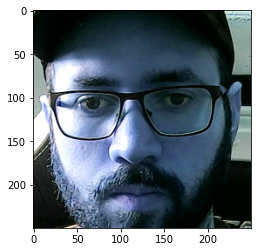

In [14]:
plt.imshow(frame[0:120+250,0:200+250, :])

# 2.x NEW - Data Augmentation

A função abaixo realiza o aumento de dados caso a amostragem seja pequena. No caso para aumentar a quantidade de dados, a função recebe a imagem como parâmetro e gera novas imagens baseadas na imagem informada, fazendo alterações nela, como: alterar o brilho, inverter a imagem, virar a imagem para direita ou esquerda, alterar a saturação, etc. Gerando assim, imagens semelhantes com algumas diferenças entre elas.

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [18]:
img_path = os.path.join(ANC_PATH, 'd0cf4b1c-70d9-11ed-8403-298e54280f9a.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [19]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

Nessa seção iremos carregar e pre-processar as imagens que salvamos.

## 3.1 Get Image Directories

Aqui vamos utilizar o tensorflow para carregar as imagens salvas. Assim, podemos iterar sobre cada imagem de cada deretório.

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [21]:
dir_test = anchor.as_numpy_iterator()

In [22]:
print(dir_test.next())

b'data/anchor/ed8607be-70d9-11ed-8403-298e54280f9a.jpg'


## 3.2 Preprocessing - Scale and Resize

A função abaixo faz o processamento da imagem. A função recebe como parâmetro o caminho completo da imagem a ser processada. Em seguida essa imagem é redimensionada para 100x100. Após ser redimensionada, ela é transformada para que fique em uma escala representada em números entre 0 e 1.

In [23]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [24]:
img = preprocess('data/anchor/d0cf4b1c-70d9-11ed-8403-298e54280f9a.jpg')

In [25]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

Vamos rotular os dados. 

Para cada par (anchor, positive) vamos definir como verdadeiro(1). Para cada par (anchor, negative) vamos definir como falso(0).

In [179]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [26]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [27]:
samples = data.as_numpy_iterator()

In [28]:
exampple = samples.next()

In [29]:
exampple

(b'data/anchor/ef062d3a-70d9-11ed-8403-298e54280f9a.jpg',
 b'data/positive/2363a512-70da-11ed-8403-298e54280f9a.jpg',
 1.0)

## 3.4 Build Train and Test Partition

Para cada par (imagem_entrada, imagem_validacao) vamos realizar o pre-processamento das imagens por meio do método que criamos anteriormente(`preprocess`) e vamos retornar as imagens pre-processadas com seu respectivo label.

In [30]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [31]:
res = preprocess_twin(*exampple)

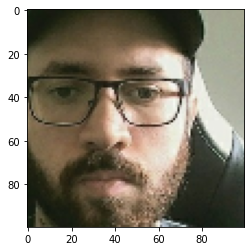

In [32]:
plt.imshow(res[1])

In [33]:
res[2]

1.0

Vamos construir o dataset embaralhando os dados.

In [34]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

Vamos coletar 70% dos dados para treino com batch de tamanho 16.

In [35]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

Vamos coletar 30% dos dados para teste com batch de tamanho 16.

In [36]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

Nessa seção iremos construir nosso modelo. Esse modelo é baseado no modelo proposto no artigo desse experimento.

## 4.1 Build Embedding Layer

Precisamos criar inicialmente nossa camada de entrada. Nesse caso essa camada vai receber uma imagem 100x100. O código da camada está logo abaixo.

In [37]:
inp = Input(shape=(100,100,3), name='input_image')

Após criamos a camada de entrada, precisamos criar a próxima camada. 
Será criada uma camada convolucional com 64 filtros e dimensão 10x10.
E com a função relu como ativação.

In [38]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

A próxima camada será a camada max pooling. Essa camada reduz a amostra da entrada ao longo de suas dimensões espaciais (altura e largura) tomando o valor máximo em uma janela de entrada (de tamanho definido pelo parâmetro de entrada chamado `pool_size`) para cada canal da entrada. Aqui definimos o `pool_size` igual a (2,2), bem como teremos 64 unidades nessa camada.

Além disso, vamos utilizar o `padding` igual a `same`. Isso resultará no preenchimento uniforme da entrada, de modo que a saída tenha a mesma dimensão de altura/largura que a entrada.

In [39]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

Agora vamos criar mais quatro camadas com o mesmo entendimento das camadas que criamos anteriormente, porém com parâmetros diferentes.

Vamos criar uma camada convulucional `c2` com 128 filtros e dimensão 7x7 e ativação relu.
Criaremos também uma camada de max pooling(`m2`) com 64 unidades, bem como pool_size igual a (2,2) e padding igual a same.

In [40]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

Vamos criar uma camada convulucional `c3` com 128 filtros e dimensão 4x4 e ativação relu.
Criaremos também mais uma camada de max pooling(`m3`) com 64 unidades, bem como pool_size igual a (2,2) e padding igual a same.

In [41]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

Vamos criar uma camada convulucional `c4` com 128 filtros e dimensão 4x4 e ativação relu.
Criaremos uma camada `Flatten`. Essa camada é usada para converter as matrizes resultantes das camadas anteriores em um único vetor linear que será passado para a próxima camada.
Na próxima camada teremos uma camada densa com 4096 unidades. Esse valor é resultante da dimensão da camada `c4`, pois temos $ 256\times4\times4 = 4096$. E usaremos a função de ativação sigmoid.

In [42]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

Aqui criamos o modelo com as camadas criadas anteriormente.

In [43]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

Aqui temos o resumo do modelo criado.

In [44]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

A função abaixo facilita a criação do modelo que foi demonstrado anteriormente, pois criaremos o modelo apenas com a chamada de um único método. Porém, o modelo criado aqui é o mesmo do explicado anteriormente.

In [45]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
embedding = make_embedding()

In [47]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

Aqui vamos criar uma `Distance Layer`. Ela irá calcular e nos dizer o quão similar as imagens que estão sendo comparadas são. 

In [48]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [49]:
l1 = L1Dist()

## 4.3 Make Siamese Model

Nessa parte vamos criar o Siamese Model. No qual receberá dois inputs, a imagem de entrada e a imagem de validação.
Ambas imagens serão passadas para o modelo que criamos anteriormente e serão processadas pelas camadas que criamos.

In [50]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [51]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

Após processar as imagens no modelo, vamos agora calulcar a distância entre elas e logo em seguida vamos classificar para ver o quão similar ambas as imagens são. Para isso vamos utilizar a camada `Distance Layer` que criamos anteriormente.

Após isso, enviaremos o resultado das distâncias para uma camada densa que irá utilizar a função sigmoid para realizar a classificação.

In [52]:
siamese_layer = L1Dist()

In [53]:
distances = siamese_layer(inp_embedding, val_embedding)

In [54]:
classifier = Dense(1, activation='sigmoid')(distances)

In [55]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [56]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

Aqui temos um método `make_siamese_model` para criar tudo o que fizemos anteriormente.

In [58]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
siamese_model = make_siamese_model()

In [60]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

Nessa seção vamos definir os parâmetros para treinamento do modelo.

## 5.1 Setup Loss and Optimizer

Aqui vamos criar a função de perda `BinaryCrossentropy`, ela calcula a perda de entropia cruzada entre rótulos verdadeiros e rótulos previstos.
Também vamos definir uma função de otimização Adam. A otimização Adam é um método estocástico de gradiente descendente.

In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [62]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

Aqui vamos definir os checkpoints no treinamento.
Iremos salvar os checkpoint no diretório `./training_checkpoints`.
Temos também a variável `checkpoint_prefix` ela irá auxiliar para adicionar o prefixo `ckpt` para cada arquivo salvo no diretório.
E temos o `checkpoint` que recebe como parâmetro o modelo e o otimizador que criamos anteriormente.

In [63]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

Temos aqui apenas uma amostragem dos dados de treino e teste. O batch será de tamanho 16 e cada item nesse batch é representado por vetores.

In [64]:
test_batch = train_data.as_numpy_iterator()

In [65]:
batch_1 = test_batch.next()

In [66]:
X = batch_1[:2]

In [67]:
y = batch_1[2]

In [68]:
y

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

Temos abaixo o método que realizará os passos do treino. 
* As imagens(anchor, positiva, negativa) serão passadas para o modelo
* O modelo recebe as imagens
* Após o modelo processar as imagens, irá ser calculado o erro
* Após o erro ser calculado iremos calcular o gradiente
* E por fim iremos fazer o backpropagation atualizando os pesos do modelo

In [70]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

Vamos criar aqui o método de treino, no qual receberemos os dados e a quantidade e épocas que o modelo deverá ser treinado.

In [71]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

* O método recebe os dados `data` como entrada e a quantidade de épocas `EPOCHS`.
* O método irá iterar sobre cada época, e em cada época será feita uma iteração no batch dos dados.
* Serão utilizadas as métricas Precision e Recall no qual o resultado serão visualizados para cada época de treino.
* Para cada batch será calculado os passos do treino pelo método que criamos e definimos anteriormente(`train_step`)
* E por fim, a cada 10 épocas iremos criar um checkpoint utilizando a função que criamos anteriormente chamado `checkpoint`.

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

Nessa parte iremos treinar o modelo utilizando os dados de treino e 50 épocas.

In [73]:
EPOCHS = 50

In [74]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
6/6 [==============================] - 33s 5s/step
0.78202266 0.0952381 0.8

 Epoch 2/50
6/6 [==============================] - 33s 5s/step
0.6865735 0.9 0.5294118

 Epoch 3/50
6/6 [==============================] - 32s 5s/step
0.5924972 0.8604651 0.75510204

 Epoch 4/50
6/6 [==============================] - 33s 5s/step
0.39053372 0.63414633 0.8965517

 Epoch 5/50
6/6 [==============================] - 33s 5s/step
0.20364192 0.8888889 0.90909094

 Epoch 6/50
6/6 [==============================] - 33s 5s/step
0.018297497 0.9302326 0.9756098

 Epoch 7/50
6/6 [==============================] - 33s 5s/step
0.055337388 0.97619045 0.97619045

 Epoch 8/50
6/6 [==============================] - 33s 5s/step
0.046066113 0.95348835 1.0

 Epoch 9/50
6/6 [==============================] - 33s 5s/step
0.013392886 0.975 1.0

 Epoch 10/

# 6. Evaluate Model

Aqui nós vamos avaliar o desempenho do modelo utilizando os dados de teste.

## 6.1 Import Metrics

As métricas utilizadas para avaliar o modelo são o Precision e o Recall

In [75]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

Vamos definir o batch de teste dos dados.

In [76]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

Fornecemos os dados de teste para o modelo fazer a predição.

In [77]:
y_hat = siamese_model.predict([test_input, test_val])

Aqui foi definido um limiar de 0.5. Se o valor predito for maior que 0.5 iremos considerar como verdadeiro(1), caso contrário iremos considerar como falso(0)

In [78]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]

Aqui temos a visualização dos labels corretos dos dados. Podemos ver que é bem parecido com o que foi predito pelo modelo.

In [79]:
y_true

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

Agora vamos calcular as métricas. Aqui vamos calcular o Recall, no qual conseguimos obter o valor igual a 1.

In [80]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

Agora vamos calcular o Precision, no qual conseguimos obter o valor igual a 1 também.

In [81]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

Aqui percorremos todos os dados de teste e fazemos a predição. Depois calculamos o Precision e o Recall. Conseguimos obter o valor de 1 para ambos, o que significa um bom valor.

In [82]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


## 6.4 Viz Results

Aqui temos uma visualização de duas imagens do conjunto de teste. Um exemplo de uma imagem passada como entrada e outra imagem passada como validação para o modelo.

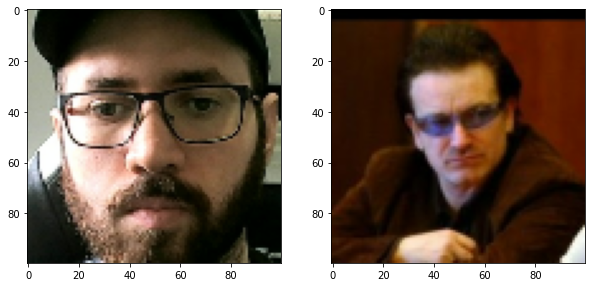

In [95]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

Vamos salvar o nosso modelo treinado anteriormente.

In [96]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [97]:
L1Dist

__main__.L1Dist

Para carregar o modelo salvo basta utilizar o modelo `load_model` do keras. Vamos passar como parâmetro o nome do arquivo em que foi salvo o modelo treinado. Passamos também a camada `Distance Layer` que criamos e também a loss function BinaryCrossentropy que foi utilizada.

In [98]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

Após carregar o modelo salvo, podemos utilizá-lo para fazer predições normalmente. Veja no código abaixo.

In [99]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[2.2058536e-08],
       [1.3163623e-05],
       [9.9999738e-01],
       [4.0817073e-07]], dtype=float32)

Aqui temos o resumo do modelo.

In [100]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

Vamos fazer um teste em tempo real utilizando para isso a webcam.

## 8.1 Verification Function

Precisamos criar um diretório chamado `application_data`. Dentro desse diretório teremos dois diretórios: `verification_images` e o `input_image`. No diretório `verification_images` iremos colocar as imagens que serão utilizadas para verificação. Nesse caso vamos utilizar as mesmas imagens que coletamos pela webcam no início desse experimento.

No diretório `input_image` iremos colocar a imagem capturada pela webcam em tempo real no qual será utilizada como fonte de comparação para que o modelo avalie e nos diga se a imagem da pessoa na webcam é de alguém válido ou não.

In [101]:
# Make the directories
if os.path.exists('application_data/verification_images'):
    shutil.rmtree('application_data/verification_images')
if os.path.exists('application_data/input_image'):
    shutil.rmtree('application_data/input_image')

os.makedirs('application_data/verification_images')
os.makedirs('application_data/input_image')

In [103]:
os.listdir(os.path.join('application_data', 'verification_images'))

['23bdde2e-70da-11ed-8403-298e54280f9a.jpg',
 '22fc7658-70da-11ed-8403-298e54280f9a.jpg',
 '22d32230-70da-11ed-8403-298e54280f9a.jpg',
 '22de4b74-70da-11ed-8403-298e54280f9a.jpg',
 '22dda818-70da-11ed-8403-298e54280f9a.jpg',
 '23a7862e-70da-11ed-8403-298e54280f9a.jpg',
 '23b402a0-70da-11ed-8403-298e54280f9a.jpg',
 '22d3efd0-70da-11ed-8403-298e54280f9a.jpg',
 '22de73e2-70da-11ed-8403-298e54280f9a.jpg',
 '23d2f336-70da-11ed-8403-298e54280f9a.jpg',
 '23b3b7fa-70da-11ed-8403-298e54280f9a.jpg',
 '24e544ae-70da-11ed-8403-298e54280f9a.jpg',
 '23fccde6-70da-11ed-8403-298e54280f9a.jpg',
 '22d2fc06-70da-11ed-8403-298e54280f9a.jpg',
 '22d2d028-70da-11ed-8403-298e54280f9a.jpg',
 '23d345c0-70da-11ed-8403-298e54280f9a.jpg',
 '23b30760-70da-11ed-8403-298e54280f9a.jpg',
 '22d3a32c-70da-11ed-8403-298e54280f9a.jpg',
 '23be061a-70da-11ed-8403-298e54280f9a.jpg',
 '23c9cad6-70da-11ed-8403-298e54280f9a.jpg',
 '23c8979c-70da-11ed-8403-298e54280f9a.jpg',
 '23a83ea2-70da-11ed-8403-298e54280f9a.jpg',
 '22fd11c6

In [104]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [105]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/23bdde2e-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22fc7658-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22d32230-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22de4b74-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22dda818-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/23a7862e-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/23b402a0-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22d3efd0-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/22de73e2-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/23d2f336-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/23b3b7fa-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/24e544ae-70da-11ed-8403-298e54280f9a.jpg
application_data/verification_images/23fccde6-70da-11ed-8403-298

O método abaixo será utilizado para fazer a verificação da imagem da webcam e as imagens que temos para validação.

O modelo irá receber ambas as imagens e irá fazer uma predição em relação as imagens. Iremos utilizar o resultado da predição para indicar se a pessoa na webcam é de alguém válido ou não.

A verificação será dado por: $(\text{proporção das predições positivas}\div \text{total de imagens positivas}) $

O resultado dessa verificação será comparada com um limiar(`verification_threshold`). Se o valor for maior que o limiar dizemos que a imagem na câmera é de alguém válido, caso contrário dizemos que não é de alguém válido.

In [106]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

Vamos utilizar o OpenCV para capturar a câmera. Ao pressionar a tecla `v` será capturada a imagem para verificação. Essa imagem será utilizada para verificação no método que criamos anteriormente. Aqui estamos utilizando como limiar o valor de 0.5.

Se a pessoa que está sendo exibida na câmera for de alguém válido, será exibido o valor `True` no terminal, caso não seja de alguém válido será exibido o valor `False` no terminal.


Ao pressionar a tecla `q` o código será encerrado, bem como a captura da webcam pelo OpenCV.

In [115]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
     
    # Ao pressionar a tecla 'v', faz a captura da imagem e salva no diretório 'input_image'
    if cv2.waitKey(33) == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Fazemos a verificação da imagem. Se for válido imprime True, caso contrário imprime 'Else'
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
        
    # Fecha a câmera
    if cv2.waitKey(33) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [110]:
np.sum(np.squeeze(results) > 0.9)

35

In [111]:
results

[array([[0.9619598]], dtype=float32),
 array([[0.61126447]], dtype=float32),
 array([[0.76223254]], dtype=float32),
 array([[0.9999461]], dtype=float32),
 array([[0.8709861]], dtype=float32),
 array([[0.7168493]], dtype=float32),
 array([[0.9996805]], dtype=float32),
 array([[0.73804176]], dtype=float32),
 array([[0.99994993]], dtype=float32),
 array([[0.919181]], dtype=float32),
 array([[0.99993294]], dtype=float32),
 array([[0.87705904]], dtype=float32),
 array([[0.995075]], dtype=float32),
 array([[0.7956004]], dtype=float32),
 array([[0.9987937]], dtype=float32),
 array([[0.9985559]], dtype=float32),
 array([[0.999905]], dtype=float32),
 array([[0.99856436]], dtype=float32),
 array([[0.5511309]], dtype=float32),
 array([[0.9999047]], dtype=float32),
 array([[0.8903098]], dtype=float32),
 array([[0.995433]], dtype=float32),
 array([[0.799749]], dtype=float32),
 array([[0.69921786]], dtype=float32),
 array([[0.99457157]], dtype=float32),
 array([[0.9999368]], dtype=float32),
 array([